# "Monte Carlo 6: Off-Policy Control with Importance Sampling in Reinforcement Learning"

> Find the optimal policy using Weighted Importance Sampling
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/MCControl_OffPolicy.png
- categories: [Reinforcement_Learning,MC,  OpenAI,Gym,]
- show_tags: true

In [1]:
# hide
# inspired by 
# https://github.com/dennybritz/reinforcement-learning/blob/master/MC/Off-Policy%20MC%20Control%20with%20Weighted%20Importance%20Sampling%20Solution.ipynb

In [2]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC/'

Mounted at /content/gdrive


In [3]:
# hide
%cd "{base_dir}"

/content/gdrive/My Drive/Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC


In [4]:
# hide
!pwd

/content/gdrive/My Drive/Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC


## 1. Introduction

In a *Markov Decision Process* (Figure 1) the *agent* and *environment* interacts continuously.

![Figure 1  Agent/Environment interaction in a MDP](../images/mc-prediction_agent-environment_fig1.png "Figure 1  Agent/Environment interaction in a MDP")

More details are available in [Reinforcement Learning: An Introduction by Sutton and Barto](http://incompleteideas.net/book/RLbook2020.pdf).

The dynamics of the MDP is given by
$$ 
\begin{aligned}
p(s',r|s,a) &= Pr\{ S_{t+1}=s',R_{t+1}=r | S_t=s,A_t=a \} \\
\end{aligned}
$$

The *policy* of an agent is a mapping from the current state of the environment to an *action* that the agent needs to take in this state. Formally, a policy is given by
$$ 
\begin{aligned}
\pi(a|s) &= Pr\{A_t=a|S_t=s\}
\end{aligned}
$$

The discounted *return* is given by
$$ 
\begin{aligned}
G_t &= R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... + R_T \\
    &= \sum_{k=0}^\infty \gamma ^k R_{t+1+k}
\end{aligned}
$$
where $\gamma$ is the discount factor and $R$ is the *reward*.

Most reinforcement learning algorithms involve the estimation of value functions - in our present case, the *state-value function*. The state-value function maps each state to a measure of "how good it is to be in that state" in terms of expected rewards. Formally, the state-value function, under policy $\pi$ is given by
$$ 
\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_t|S_t=s]
\end{aligned}
$$

The Monte Carlo algorithm discussed in this post will numerically estimate $v_\pi(s)$.

## 2. Environment

The environment is the game of *Blackjack*. The player tries to get cards whose sum is as great as possible without exceeding 21. Face cards count as 10. An ace can be taken either as a 1 or an 11. Two cards are dealth to both dealer and player. One of the dealer's cards is face up (other is face down). The player can request additional cards, one by one (called *hits*) until the player stops (called *sticks*) or goes above 21 (goes *bust* and loses). When the players sticks it becomes the dealer's turn which uses a fixed strategy: sticks when the sum is 17 or greater and hits otherwise. If the dealer goes bust the player wins, otherwise the winner is determined by whose sum is closer to 21.

We formulate this game as an episodic finite MDP. Each game is an episode. 

* States are based on the player's
  * current sum (12-21)
    * player will automatically keep on getting cards until the sum is at least 12 (this is a rule and the player does not have a choice in this matter)
  * dealer's face up card (ace-10)
  * whether player holds usable ace (True or False)

This gives a total of 200 states: $10 × 10 \times 2 = 200$

* Rewards:
  * +1 for winning
  * -1 for losing
  * 0 for drawing

* Reward for stick:
  * +1 if sum > sum of dealer
  * 0 if sum = sum of dealer
  * -1 if sum < sum of dealer

* Reward for hit:
  * -1 if sum > 21
  * 0 otherwise

The environment is implemented using the OpenAI Gym library.

## 3. Agent

The *agent* is the player. After observing the state of the *environment*, the agent can take one of two possible actions:

* stick (0) [stop receiving cards]
* hit (1) [have another card]

The agent's policy will be deterministic - will always stick of the sum is 20 or 21, and hit otherwise. We call this *policy1* in the code.

## 4. Monte Carlo Estimation of the Action-value Function, $q_\pi(s,a)$

We will now proceed to estimate the action-value function for the given policy $\pi$. We can take $\gamma=1$ as the sum will remain finite:

$$ \large
\begin{aligned}
q_\pi(s,a) &= \mathbb{E}_\pi[G_t | S_t=s, A_t=a] \\
         &= \mathbb{E}_\pi[R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... + R_T | S_t=s, A_t=a] \\
         &= \mathbb{E}_\pi[R_{t+1} + R_{t+2} + R_{t+3} + ... + R_T | S_t=s, A_t=a]
\end{aligned}
$$

In numeric terms this means that, given a state and an action, we take the sum of all rewards from that state onwards (following policy $\pi$) until the game ends, and take the average of all such sequences.


### 4.1 Off-policy Estimation via Importance Sampling

On-policy methods, used so far in this series, represents a compromise. They learn action values not for the optimal policy but for a near-optimal policy that can still explore. The off-policy methods, on the other hand, make use of *two* policies -  one that is being optimized (called the *target* policy) and another one (the *behavior* policy) that is used for exploratory purposes. 

An important concept used by off-policy methods is *importance sampling*. This is a general technique for extimating expected values under one distribution by using samples from another. This allows us to weight returns according to the relative probability of a trajectory occurring under the target and behavior policies. This relative probability is called the importance-sampling ratio

$$ \large
\rho_{t:T-1}=\frac{\prod_{k=t}^{T-1} \pi(A_k|S_k) p(S_{k+1}|S_k,A_k)}{\prod_{k=t}^{T-1} b(A_k|S_k) p(S_{k+1}|S_k,A_k)}=∏_{k=t}^{T-1} \frac{\pi(A_k|S_k)}{b(A_k|S_k)}
$$

where $\pi$ is the *target* policy, and $b$ is the *behavior* policy.

In oder to estimate $q_{\pi}(s,a)$ we need to estimate expected returns under the target policy. However, we only have access to returns due to the behavior 
policy. To perform this "off-policy" procedure we can make use of the following:

$$ \large
\begin{aligned}
q_\pi(s,a) &= \mathbb E_\pi[G_t|S_t=s, A_t=a] \\
           &= \mathbb E_b[\rho_{t:T-1}G_t|S_t=s, A_t=a]
\end{aligned}
$$

This allows us to simply scale or weight the returns under $b$ to yield returns under $\pi$.

In our current *prediction* problem, both the target and behavior policies are fixed.

## 5. Implementation

Figure 1 shows the algorithm for off-policy control for the estimation of the optimal policy function:

![Figure 1  MCControl, Off-Policy, for estimating the optimal policy](../images/MCControl_OffPolicy_fig1.png "Figure 1  MCControl, Off-Policy, for estimating the optimal policy")

Next, we present the code that implements the algorithm.

In [5]:
import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
import pprint as pp
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
# hide
from lib import plotting as myplot
from lib.envs.blackjack import BlackjackEnv

In [7]:
# hide
# env = gym.make('Blackjack-v0')#.has differences cp to the one used here
#- env = gym.make('Blackjack-v1')#.does not exist

In [8]:
env = BlackjackEnv()

### 5.1 Policy

The following function captures the target policy used:

In [9]:
def create_random_policy(n_A):
    A = np.ones(n_A, dtype=float)/n_A
    def policy_function(observation):
        return A
    return policy_function #vector of action probabilities

In [10]:
# hide
# def create_greedy_policy(Q):
#   def policy_function(state):
#     A = np.zeros_like(Q[state], dtype=float)
#     best_action = np.argmax(Q[state])
#     A[best_action] = 1.0
#     return A
#   return policy_function

In [11]:
# hide
# def create_policy():
#   policy = defaultdict(int)
#   for sum in [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]:
#     for showing in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
#       for usable in [False, True]:
#         policy[(sum, showing, usable)] = np.random.choice([0, 1]) #random
#         # policy[(sum, showing, usable)] = 0 #all zeros
#   return policy

In [12]:
def create_policy():
  policy = defaultdict(int)
  return policy

### 5.2 Generate episodes

The following function sets the environment to a random initial state. It then enters a loop where each iteration applies the policy to the environment's state to obtain the next action to be taken by the agent. That action is then applied to the environment to get the next state, and so on until the episode ends.

In [13]:
def generate_episode(env, policy):
  episode = []
  state = env.reset() #to a random state
  while True:
      probs = policy(state)
      action = np.random.choice(np.arange(len(probs)), p=probs)
      next_state, reward, done, _ = env.step(action) # St+1, Rt+1 OR s',r
      episode.append((state, action, reward)) # St, At, Rt+1 OR s,a,r
      if done:
          break
      state = next_state
  return episode

### 5.3 Main loop

The following function implements the main loop of the algorithm. It iterates for ``n_episodes``. It also takes a list of ``monitored_state_actions`` for which it will record the evolution of action values. This is handy for showing how action values converge during the process.

In [14]:
def mc_control(env, n_episodes, discount_factor=1.0, monitored_state_actions=None, diag=False):
  G_sum = defaultdict(float)
  G_count = defaultdict(float)
  Q = defaultdict(lambda: np.zeros(env.action_space.n))
  C = defaultdict(lambda: np.zeros(env.action_space.n))
  pi = create_policy()
  monitored_state_action_values = defaultdict(list)
  for i in range(1, n_episodes + 1):
    if i%1000 == 0: print("\rEpisode {}/{}".format(i, n_episodes), end=""); sys.stdout.flush()
    b = create_random_policy(env.action_space.n)
    episode = generate_episode(env, b); print(f'\nepisode {i}: {episode}') if diag else None
    G = 0.0
    W = 1.0
    for t in range(len(episode))[::-1]:
      St, At, Rtp1 = episode[t]
      print(f"---t={t} St, At, Rt+1: {St, At, Rtp1}") if diag else None
      G = discount_factor*G + Rtp1; print(f"G: {G}") if diag else None
      C[St][At] += W; print(f"C[St][At]: {C[St][At]}") if diag else None #Weighted Importance Sampling (WIS) denominator
      Q[St][At] += (W/C[St][At])*(G - Q[St][At]); print(f"Q[St][At]: {Q[St][At]}") if diag else None
      pi[St] = np.argmax(Q[St]) #greedify pi, max_a Q[state][0], Q[state][1]
      if At != np.argmax(pi[St]):
        break
      W = W*1.0/b(St)[At]; print(f"W: {W}, b(St)[At]: {b(St)[At]}") if diag else None
    if monitored_state_actions:
      for msa in monitored_state_actions: 
        s = msa[0]; a = msa[1]            
        # print("\rQ[{}]: {}".format(msa, Q[s][a]), end=""); sys.stdout.flush()
        monitored_state_action_values[msa].append(Q[s][a])
  print('\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++') if diag else None
  pp.pprint(f'G_sum: {G_sum}') if diag else None
  pp.pprint(f'G_count: {G_count}') if diag else None
  print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++') if diag else None
  print('\nmonitored_state_action_values:', monitored_state_action_values) if diag else None
  return Q,pi,monitored_state_action_values    

### 5.4 Monitored state-actions

Let's pick a number of state-actions to monitor. Each tuple captures the player's sum, the dealer's showing card, and whether the player has a usable ace, as well as the action taken in the state:

In [15]:
monitored_state_actions=[((21, 7, False), 0), ((20, 7, True), 0), ((12, 7, False), 1), ((17, 7, True), 0)]

In [16]:
Q,pi,monitored_state_action_values = mc_control(
  env, 
  n_episodes=10, 
  monitored_state_actions=monitored_state_actions,
  diag=True)


episode 1: [((15, 3, False), 1, 0), ((19, 3, False), 1, -1)]
---t=1 St, At, Rt+1: ((19, 3, False), 1, -1)
G: -1.0
C[St][At]: 1.0
Q[St][At]: -1.0

episode 2: [((18, 1, False), 0, -1)]
---t=0 St, At, Rt+1: ((18, 1, False), 0, -1)
G: -1.0
C[St][At]: 1.0
Q[St][At]: -1.0
W: 2.0, b(St)[At]: 0.5

episode 3: [((20, 10, False), 0, 1)]
---t=0 St, At, Rt+1: ((20, 10, False), 0, 1)
G: 1.0
C[St][At]: 1.0
Q[St][At]: 1.0
W: 2.0, b(St)[At]: 0.5

episode 4: [((20, 6, False), 0, 1)]
---t=0 St, At, Rt+1: ((20, 6, False), 0, 1)
G: 1.0
C[St][At]: 1.0
Q[St][At]: 1.0
W: 2.0, b(St)[At]: 0.5

episode 5: [((15, 3, True), 1, 0), ((15, 3, False), 0, -1)]
---t=1 St, At, Rt+1: ((15, 3, False), 0, -1)
G: -1.0
C[St][At]: 1.0
Q[St][At]: -1.0
W: 2.0, b(St)[At]: 0.5
---t=0 St, At, Rt+1: ((15, 3, True), 1, 0)
G: -1.0
C[St][At]: 2.0
Q[St][At]: -1.0

episode 6: [((13, 4, False), 0, 1)]
---t=0 St, At, Rt+1: ((13, 4, False), 0, 1)
G: 1.0
C[St][At]: 1.0
Q[St][At]: 1.0
W: 2.0, b(St)[At]: 0.5

episode 7: [((14, 9, False), 0, -

In [17]:
Q

defaultdict(<function __main__.mc_control.<locals>.<lambda>>,
            {(12, 7, False): array([0., 0.]),
             (13, 4, False): array([1., 0.]),
             (14, 9, False): array([-1.,  0.]),
             (15, 3, False): array([-1.,  0.]),
             (15, 3, True): array([ 0., -1.]),
             (16, 7, False): array([-1.,  0.]),
             (17, 7, True): array([0., 0.]),
             (17, 10, False): array([ 0., -1.]),
             (18, 1, False): array([-1.,  0.]),
             (19, 3, False): array([ 0., -1.]),
             (20, 6, False): array([1., 0.]),
             (20, 7, True): array([0., 0.]),
             (20, 10, False): array([1., 0.]),
             (21, 6, False): array([0., 0.]),
             (21, 7, False): array([0., 0.])})

In [18]:
Q[(13, 5, False)]

array([0., 0.])

In [19]:
pi

defaultdict(int,
            {(13, 4, False): 0,
             (14, 9, False): 1,
             (15, 3, False): 1,
             (15, 3, True): 0,
             (16, 7, False): 1,
             (17, 10, False): 0,
             (18, 1, False): 1,
             (19, 3, False): 0,
             (20, 6, False): 0,
             (20, 10, False): 0,
             (21, 6, False): 0})

In [20]:
pi[(18, 4, False)]

0

In [21]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

In [22]:
V

defaultdict(float,
            {(12, 7, False): 0.0,
             (13, 4, False): 1.0,
             (13, 5, False): 0.0,
             (14, 9, False): 0.0,
             (15, 3, False): 0.0,
             (15, 3, True): 0.0,
             (16, 7, False): 0.0,
             (17, 7, True): 0.0,
             (17, 10, False): 0.0,
             (18, 1, False): 0.0,
             (19, 3, False): 0.0,
             (20, 6, False): 1.0,
             (20, 7, True): 0.0,
             (20, 10, False): 1.0,
             (21, 6, False): 0.0,
             (21, 7, False): 0.0})

In [23]:
print(monitored_state_actions[0])
print(monitored_state_action_values[monitored_state_actions[0]])

((21, 7, False), 0)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [24]:
# 
# last value in monitored_state_actions should be value in Q
msa = monitored_state_actions[0]; print('msa:', msa)
s = msa[0]; print('s:', s)
a = msa[1]; print('a:', a)
monitored_state_action_values[msa][-1], Q[s][a] #monitored_stuff[msa] BUT Q[s][a]

msa: ((21, 7, False), 0)
s: (21, 7, False)
a: 0


(0.0, 0.0)

### 5.5 Run 1

First, we will run the algorithm for 10,000 episodes, using policy1:

In [25]:
Q1,pi1,monitored_state_action_values1 = mc_control(
    env, 
    n_episodes=10_000, 
    monitored_state_actions=monitored_state_actions,
    diag=False)

Episode 10000/10000

In [26]:
# 
# last value in monitored_state_actions should be value in Q
msa = monitored_state_actions[0]; print('msa:', msa)
s = msa[0]; print('s:', s)
a = msa[1]; print('a:', a)
monitored_state_action_values1[msa][-1], Q1[s][a] #monitored_stuff[msa] BUT Q[s][a]

msa: ((21, 7, False), 0)
s: (21, 7, False)
a: 0


(0.9210526315789471, 0.9210526315789471)

The following chart shows how the values of the 4 monitored state-actions converge to their values:

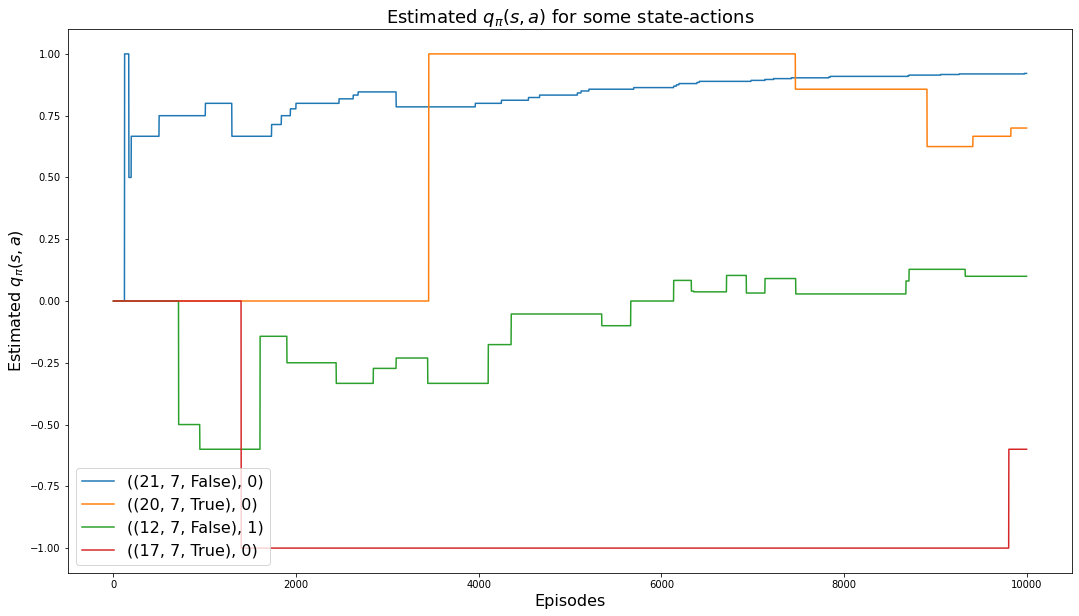

In [27]:
plt.rcParams["figure.figsize"] = (18,10)
for msa in monitored_state_actions:
  plt.plot(monitored_state_action_values1[msa])
plt.title('Estimated $q_\pi(s,a)$ for some state-actions', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $q_\pi(s,a)$', fontsize=16)
plt.legend(monitored_state_actions, fontsize=16)
plt.show()

The following charts shows the estimate of the associated estimated optimal state-value function, $v_*(s)$, for the cases of a usable ace as well as not a usable ace. First, we compute ```V1``` which is the estimate for $v_*(s)$:

In [28]:
V1 = defaultdict(float)
for state, actions in Q1.items():
    action_value = np.max(actions)
    V1[state] = action_value

In [29]:
AZIM = -110
ELEV = 20

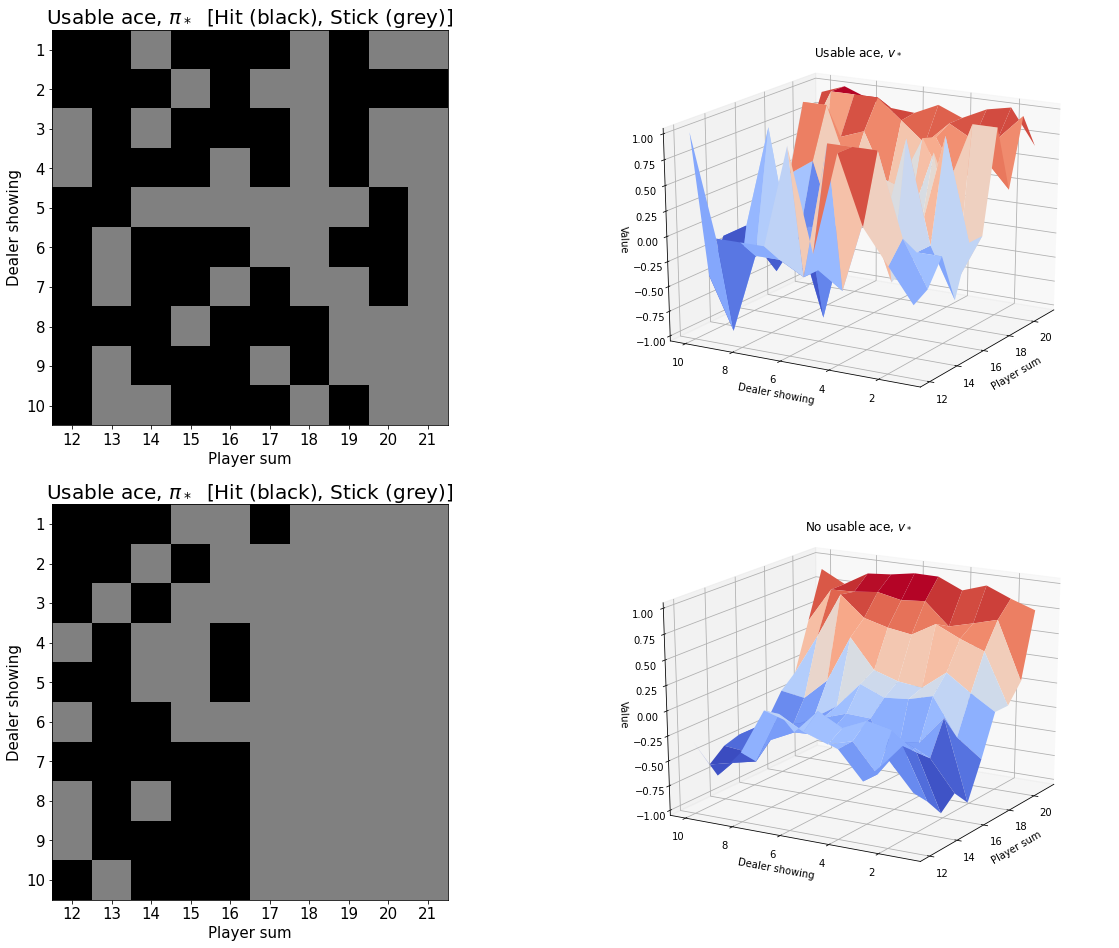

In [30]:
myplot.plot_pi_star_and_v_star(pi1, V1, title="$\pi_* and v_*$", wireframe=False, azim=AZIM-40, elev=ELEV);

### 5.6 Run 2

Our final run uses 500,000 episodes and the accuracy of the action-value function is higher.

In [31]:
Q2,pi2,monitored_state_action_values2 = mc_control(
    env, 
    n_episodes=500_000, 
    monitored_state_actions=monitored_state_actions,
    diag=False)

Episode 500000/500000

In [32]:
# 
# last value in monitored_state_actions should be value in Q
msa = monitored_state_actions[0]; print('msa:', msa)
s = msa[0]; print('s:', s)
a = msa[1]; print('a:', a)
monitored_state_action_values2[msa][-1], Q2[s][a] #monitored_stuff[msa] BUT Q[s][a]

msa: ((21, 7, False), 0)
s: (21, 7, False)
a: 0


(0.9206598586017273, 0.9206598586017273)

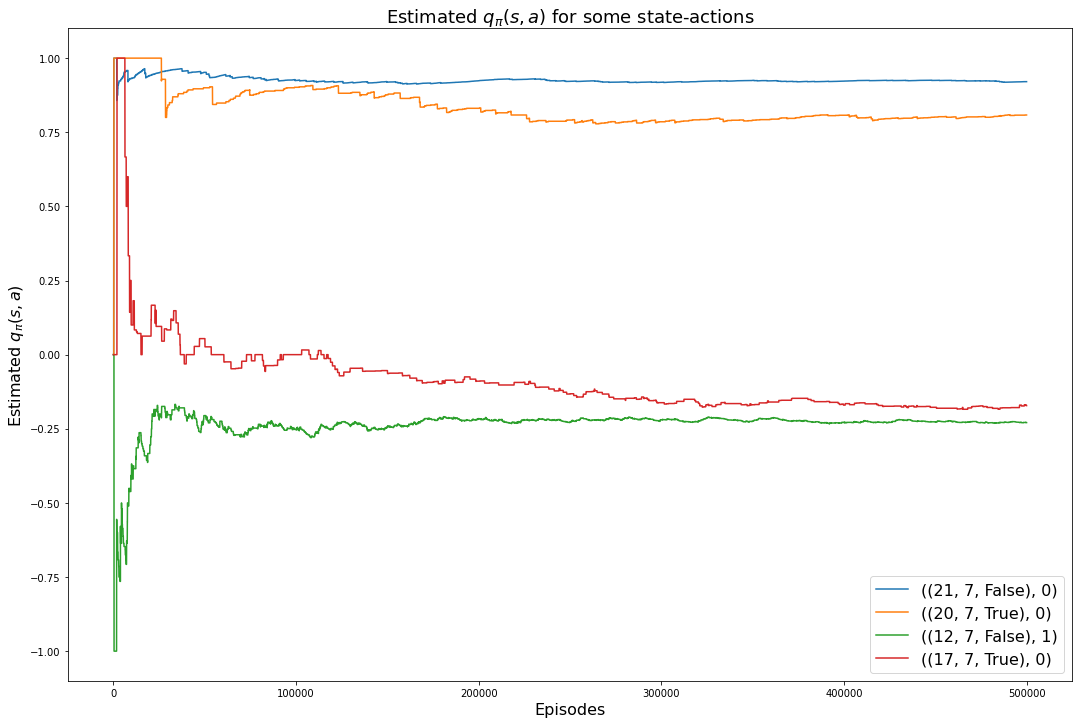

In [33]:
plt.rcParams["figure.figsize"] = (18,12)
for msa in monitored_state_actions:
  plt.plot(monitored_state_action_values2[msa])
plt.title('Estimated $q_\pi(s,a)$ for some state-actions', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $q_\pi(s,a)$', fontsize=16)
plt.legend(monitored_state_actions, fontsize=16)
plt.show()

In [34]:
V2 = defaultdict(float)
for state, actions in Q2.items():
  action_value = np.max(actions)
  V2[state] = action_value

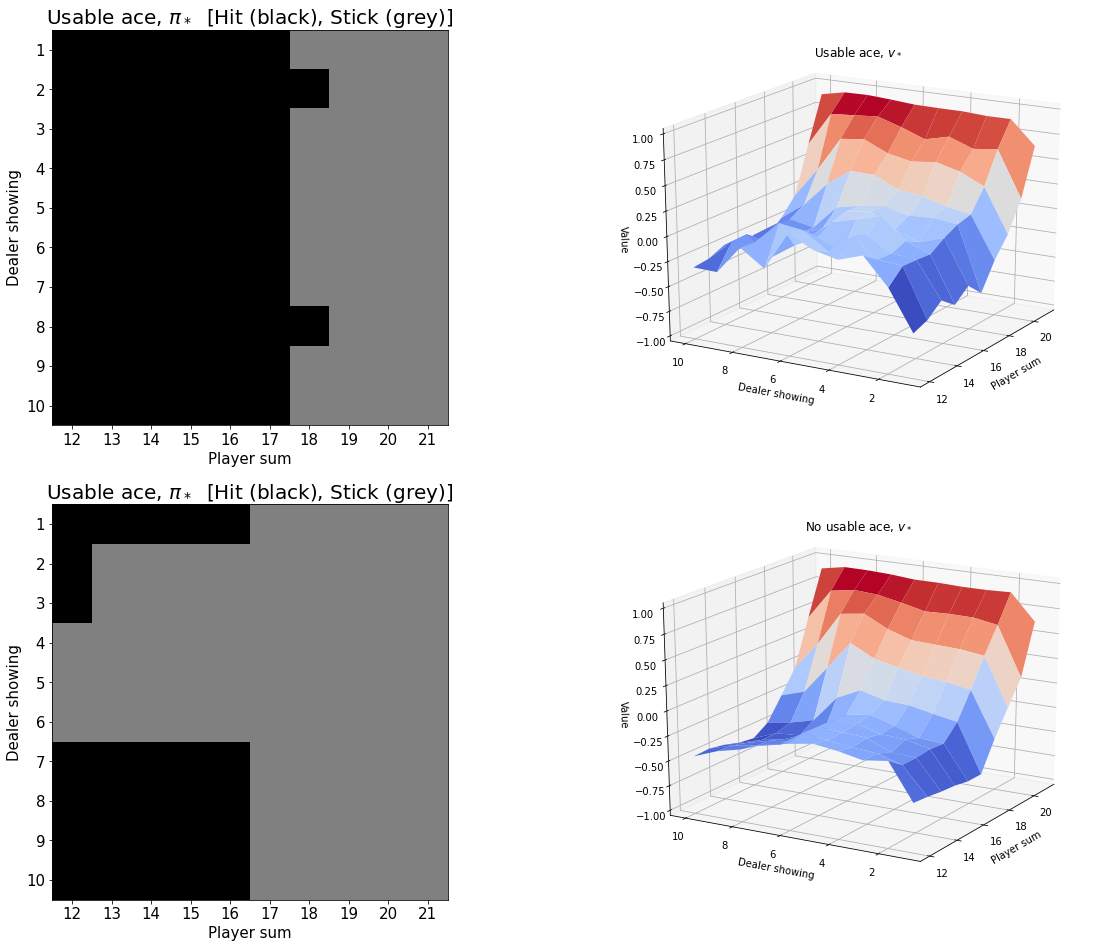

In [35]:
# myplot.plot_action_value_function(Q2, title="500,000 Steps", wireframe=True, azim=AZIM, elev=ELEV)
myplot.plot_pi_star_and_v_star(pi2, V2, title="$\pi_* and v_*$", wireframe=False, azim=AZIM-40, elev=ELEV);